<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_part2_07_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html -q

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
def sorta_import(name):
  import urllib.request
  import os
  a = urllib.request.urlopen(f'https://raw.githubusercontent.com/fastai/fastai_docs/master/dev_course/dl2/exp/{name}.py')
  os.makedirs('exp', exist_ok=True)
  with open(f'exp/{name}.py', 'wb') as f:
    f.write(a.read())
  __import__(f'exp.{name}')

def load_modules_up_to(n_inclusive):
  for i in range(n_inclusive + 1):
    try:
      sorta_import(f'nb_0{i}')
    except:
      print(f"Problem importing {i}")
      raise

load_modules_up_to(6)
sorta_import('nb_05b')
from exp.nb_06 import *

In [0]:
from torch.utils.data import TensorDataset, DataLoader
x_train,y_train,x_valid,y_valid = get_data()
n_classes = len(y_train.unique())
batch_size = 512
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle = False)

data = DataBunch(train_dl, valid_dl)

from collections import namedtuple
Stats = namedtuple('Stats', 'mean, std')

def stats(x):
  return Stats(x.mean(), x.std())

train_stats = stats(x_train)
valid_stats = stats(x_valid)
train_stats, valid_stats

def normalize(x, s):
  return (x - s.mean) / s.std

class BatchNorm(nn.Module):
  def __init__(self, momentum=0.9, eps=1e-5):
    super().__init__()
    self.eps = eps
    self.momentum = 1 - momentum

  def forward(self, x):
    BATCH,CHANNEL,X,Y = 0,1,2,3
    by_channel = (BATCH, X, Y)
    if (self.training):
      self._init_if_necessary(x)
      with torch.no_grad():
        channel_vars  = x.var(by_channel, keepdim=True)        # <-- pytorch-nightly needed
        channel_means = x.mean(by_channel, keepdim=True)
        self.means.lerp_ (channel_means, self.momentum)
        self.vars.lerp_(channel_vars, self.momentum)

    x_norm = (x - self.means) / torch.sqrt(self.vars + self.eps)
    return x_norm * self.mults + self.adds
  
  def _init_if_necessary(self, x):
    if hasattr(self, 'mults'):
      return

    dims = (1, x.shape[1], 1, 1)
    self.mults = nn.Parameter(torch.ones(dims).to(x.device))
    self.adds = nn.Parameter(torch.zeros(dims).to(x.device))
    self.register_buffer('means', torch.zeros(dims).to(x.device))
    self.register_buffer('vars', torch.ones(dims).to(x.device))

def my_conv_with_bn(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
      nn.ReLU(),
      BatchNorm()
  )

def get_my_model(conv_func=my_conv_with_bn):
  return nn.Sequential(
      Lambda(lambda m: normalize(m, train_stats)),
      Lambda(lambda m: m.view(-1, 1, 28, 28)),
      conv_func( 1, 8,  kernel_size=5, stride=2, padding=2),
      conv_func( 8, 16, kernel_size=3),
      conv_func(16, 32),
      conv_func(32, 32),
      nn.AdaptiveAvgPool2d(1),
      Lambda(lambda m: m.squeeze(-1).squeeze(-1)),
      nn.Linear(in_features = 32, out_features = n_classes)
  )

In [5]:
model = get_my_model()
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr = 1)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)

runner.fit(3, learner) 

train: [0.82315109375, tensor(0.7363, device='cuda:0')]
valid: [0.3097011474609375, tensor(0.9140, device='cuda:0')]
train: [0.28844775390625, tensor(0.9180, device='cuda:0')]
valid: [0.217281591796875, tensor(0.9399, device='cuda:0')]
train: [0.21679931640625, tensor(0.9374, device='cuda:0')]
valid: [0.17918031005859375, tensor(0.9507, device='cuda:0')]


In [0]:
# ~copypasta from 06_cuda_cnn + somewhat changed to allow using Hooks from fastai
class HistHook():
  def __init__(self, min=-10, max=10, bins=50):
    self.bins = bins
    self.min = min
    self.max = max
  
  def __call__(self, hook_param, module, input, output):
    output = output.clone().cpu().detach()
    if not hasattr(hook_param, 'histograms'):
      hook_param.histograms = []
      hook_param.averages = []
      hook_param.stds = []
    hook_param.histograms.append(torch.histc(output, bins=self.bins, min=self.min, max=self.max))
    hook_param.averages.append(torch.mean(output))
    hook_param.stds.append(torch.std(output))
    
  def plot_percentage_withinbounds(self, hists, min_bound, max_bound, ax=None):
    data = self.percentage_within_bounds(hists, min_bound, max_bound)
    if not ax: ax = plt.subplot()
    ax.set_ylim(0, 1)
    ax.plot(data)

  def total_percentage_within_bounds(self, hists, min_bound, max_bound):
    all_hists_sum = torch.stack(hists).sum()
    selected_bins_series = self._series_bins_between(hists, min_bound, max_bound)
    selected_bins_sum = selected_bins_series.sum()
    return (selected_bins_sum / all_hists_sum.float()).item()
  
  def percentage_within_bounds(self, hists, min_bound, max_bound):
    selected_bins_series = self._series_bins_between(hists, min_bound, max_bound)
    all_hists = torch.stack(hists).t()
    return (selected_bins_series.sum(0).float() / all_hists.sum(dim=0).float()).squeeze(0)

  def _series_bins_between(self, hists, min_bound, max_bound):
    assert min_bound < max_bound
    assert min_bound >= self.min
    assert max_bound <= self.max

    assert len(hists) > 0
    
    bin_width = (self.max-self.min) / self.bins
    right_bounds = self.min + torch.zeros(self.bins).fill_(bin_width).cumsum(dim=0)
    left_bounds = right_bounds - bin_width

    indexes = (left_bounds >= min_bound)*(right_bounds <= max_bound)
    assert (indexes > 0).any().item(), f"Too narrow of a range, no bins fully selected (single bin is {bin_width})"
    all_hists = torch.stack(hists).t()
    return all_hists[indexes]

In [7]:
model = get_my_model()
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr = 1)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)

hist_hook = HistHook()
with Hooks(model, hist_hook) as hooks:
  runner.fit(3, learner) 

train: [1.3962125, tensor(0.5529, device='cuda:0')]
valid: [0.393830517578125, tensor(0.8935, device='cuda:0')]
train: [0.33435046875, tensor(0.9063, device='cuda:0')]
valid: [0.241809765625, tensor(0.9280, device='cuda:0')]
train: [0.23996123046875, tensor(0.9311, device='cuda:0')]
valid: [0.19331036376953126, tensor(0.9420, device='cuda:0')]


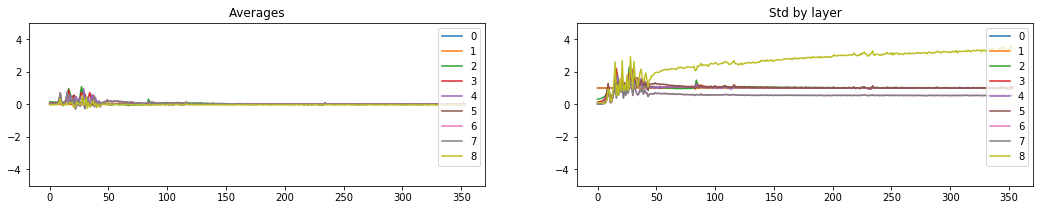

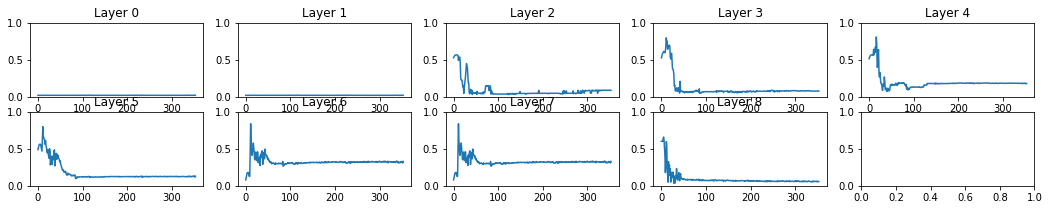

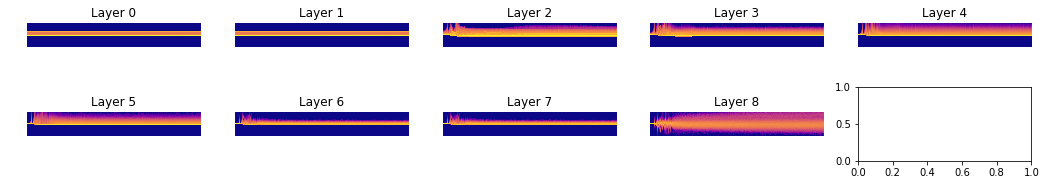

In [8]:
def draw_activations_around_zero(hooks_list):
  hist_serlies_list = list(map(lambda hook: hook.histograms, hooks_list))
  fig, axz = plt.subplots(2, 5, figsize=(18,3))
  for hist, ax, idx in zip(hist_serlies_list, axz.flatten(), range(len(hist_serlies_list))):
    ax.set_title(f'Layer {idx}')
    hist_hook.plot_percentage_withinbounds(hist, -0.4, 0.4, ax=ax)
    
def draw_activation_hists(hooks_list):
  hist_serlies_list = list(map(lambda hook: hook.histograms, hooks_list))
  fig, axz = plt.subplots(2, 5, figsize=(18,3))
  for hist_series, ax, idx in zip(hist_serlies_list, axz.flatten(), range(len(hist_serlies_list))):
    hist_series = torch.stack(hist_series).t().log1p()
    ax.axis('off')
    ax.set_title(f'Layer {idx}')
    ax.imshow(hist_series, cmap='plasma', origin='lower', interpolation='none')

def draw_avgs(hooks_list, y_bounds=(-5,5)):
  avg_serlies_list = list(map(lambda hook: hook.averages, hooks_list))
  fig, axz = plt.subplots(1, 2, figsize=(18,3))
  axz = axz.flatten()
  axz[0].set_title(f'Averages')
  for avg_series in avg_serlies_list:
    axz[0].plot(avg_series)
  axz[0].set_ylim(*y_bounds)
  axz[0].legend(range(len(avg_serlies_list)))
  
  std_serlies_list = list(map(lambda hook: hook.stds, hooks_list))
  axz[1].set_ylim(*y_bounds)
  axz[1].set_title(f'Std by layer')
  for series in std_serlies_list:
    axz[1].plot(series)
  axz[1].legend(range(len(std_serlies_list)))

draw_avgs(hooks)
draw_activations_around_zero(hooks)
draw_activation_hists(hooks)


In [9]:
model = get_my_model()
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr = 1)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)

hist_hook = HistHook()
with Hooks(model, hist_hook) as hooks:
  runner.fit(3, learner) 

train: [0.711218515625, tensor(0.7741, device='cuda:0')]
valid: [0.2507678955078125, tensor(0.9322, device='cuda:0')]
train: [0.23853904296875, tensor(0.9325, device='cuda:0')]
valid: [0.18534022216796875, tensor(0.9473, device='cuda:0')]
train: [0.18317244140625, tensor(0.9469, device='cuda:0')]
valid: [0.15315205078125, tensor(0.9583, device='cuda:0')]


train: [0.424246796875, tensor(0.8806, device='cuda:0')]
valid: [0.114647998046875, tensor(0.9642, device='cuda:0')]
train: [0.085202197265625, tensor(0.9740, device='cuda:0')]
valid: [0.06807217407226562, tensor(0.9794, device='cuda:0')]
train: [0.0588855615234375, tensor(0.9823, device='cuda:0')]
valid: [0.05974466552734375, tensor(0.9817, device='cuda:0')]


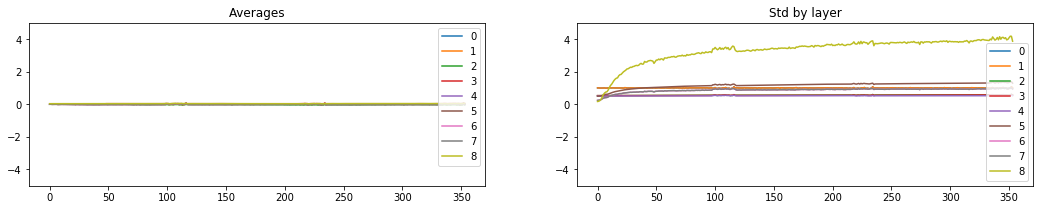

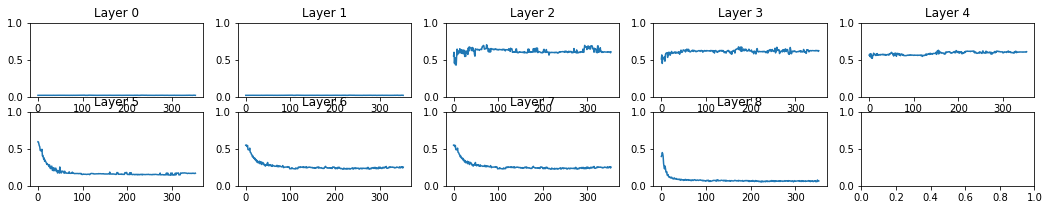

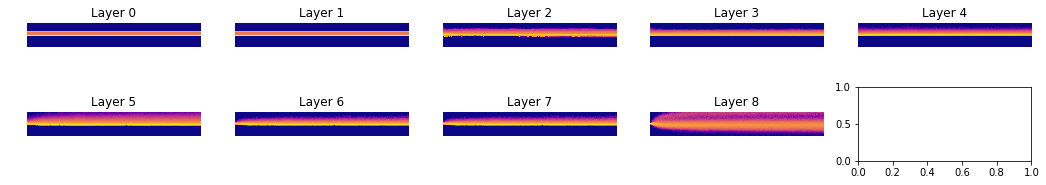

In [10]:
def my_conv_with_standard_bn(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels)
  )

def train_and_show_telemetry(model):  
  loss_func = F.cross_entropy
  opt = optim.SGD(model.parameters(), lr = 1)
  learner = Learner(model, opt, loss_func, data)

  cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
  runner = Runner(cbfs)

  hist_hook = HistHook()
  with Hooks(model, hist_hook) as hooks:
    runner.fit(3, learner)
    
  draw_avgs(hooks)
  draw_activations_around_zero(hooks)
  draw_activation_hists(hooks)

  
train_and_show_telemetry(get_my_model(my_conv_with_standard_bn))

train: [0.45264203125, tensor(0.8714, device='cuda:0')]
valid: [0.3466546875, tensor(0.8917, device='cuda:0')]
train: [0.19611251953125, tensor(0.9418, device='cuda:0')]
valid: [0.17095206298828125, tensor(0.9499, device='cuda:0')]
train: [0.152606474609375, tensor(0.9531, device='cuda:0')]
valid: [0.2071569091796875, tensor(0.9375, device='cuda:0')]


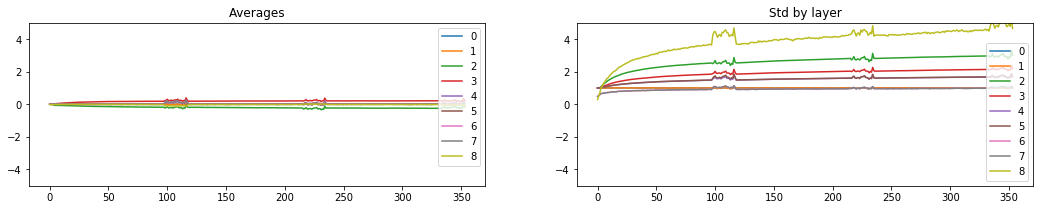

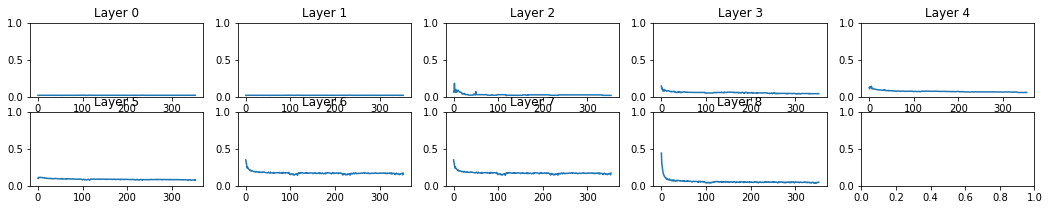

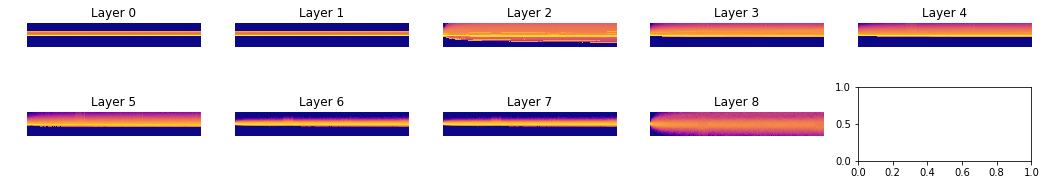

In [11]:
class FastAiBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

def my_conv_with_fastai_bn(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
      nn.ReLU(),
      FastAiBatchNorm(out_channels)
  )
      
train_and_show_telemetry(get_my_model(my_conv_with_fastai_bn))

In [12]:
%%html
Custom impl v1
<img src='https://github.com/cluePrints/fastai-v3-notes/raw/master/images/07_batch_norm_custom_v1.png' width="150"/>

Pytorch original
<img src='https://github.com/cluePrints/fastai-v3-notes/raw/master/images/07_batch_norm_standard.png' width = "150"/>


In [0]:
class BatchNormV2(nn.Module):
  def __init__(self, momentum=0.9, eps=1e-5):
    super().__init__()
    self.eps = eps
    self.momentum = 1 - momentum

  def forward(self, x):
    BATCH,CHANNEL,X,Y = 0,1,2,3
    by_channel = (BATCH, X, Y)
    if (self.training):
      self._init_if_necessary(x)
      with torch.no_grad():
        channel_vars  = x.var(by_channel, keepdim=True)
        channel_means = x.mean(by_channel, keepdim=True)
        self.means.lerp_ (channel_means, self.momentum)
        self.vars.lerp_(channel_vars, self.momentum)
    else:
      channel_vars = self.vars
      channel_means = self.means

    # Note to self: using the actual and not exp avg vals during training seem to be important!
    x_norm = (x - channel_means) / torch.sqrt(channel_vars + self.eps)
    return x_norm * self.mults + self.adds
  
  def _init_if_necessary(self, x):
    if hasattr(self, 'mults'):
      return

    dims = (1, x.shape[1], 1, 1)
    self.mults = nn.Parameter(torch.ones(dims).to(x.device))
    self.adds = nn.Parameter(torch.zeros(dims).to(x.device))
    self.register_buffer('means', torch.zeros(dims).to(x.device))
    self.register_buffer('vars', torch.ones(dims).to(x.device))

train: [0.666078125, tensor(0.8132, device='cuda:0')]
valid: [0.419826904296875, tensor(0.8744, device='cuda:0')]
train: [0.3671806640625, tensor(0.8944, device='cuda:0')]
valid: [0.2982609375, tensor(0.9110, device='cuda:0')]
train: [0.29294517578125, tensor(0.9137, device='cuda:0')]
valid: [0.2553097900390625, tensor(0.9215, device='cuda:0')]


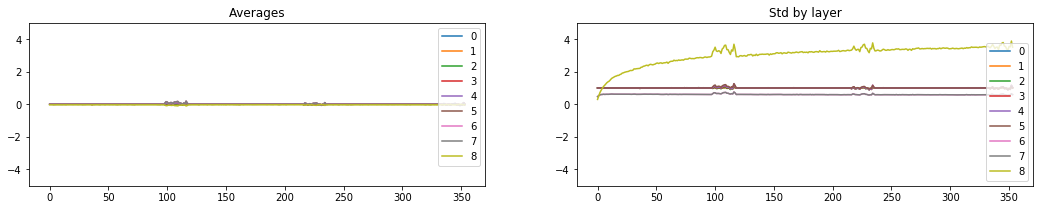

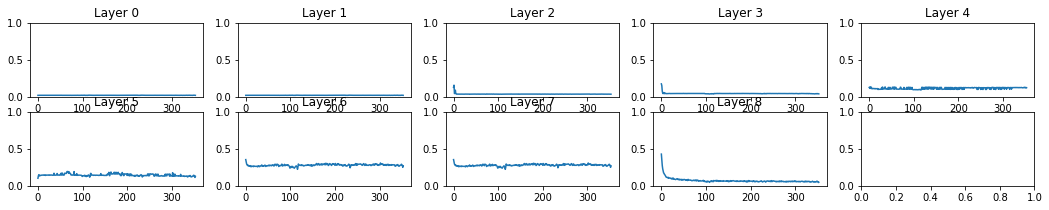

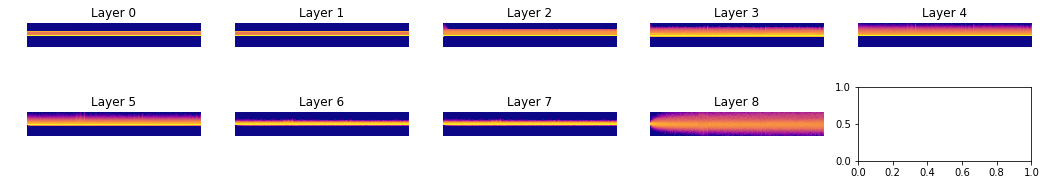

In [14]:
def my_conv_with_bn_v2(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
      nn.ReLU(),
      BatchNormV2()
  )
      
train_and_show_telemetry(get_my_model(my_conv_with_bn_v2))

train: [0.35634671875, tensor(0.8978, device='cuda:0')]
valid: [0.12650345458984374, tensor(0.9623, device='cuda:0')]
train: [0.0765484228515625, tensor(0.9768, device='cuda:0')]
valid: [0.08488490600585938, tensor(0.9751, device='cuda:0')]
train: [0.0561696435546875, tensor(0.9829, device='cuda:0')]
valid: [0.0617897216796875, tensor(0.9822, device='cuda:0')]


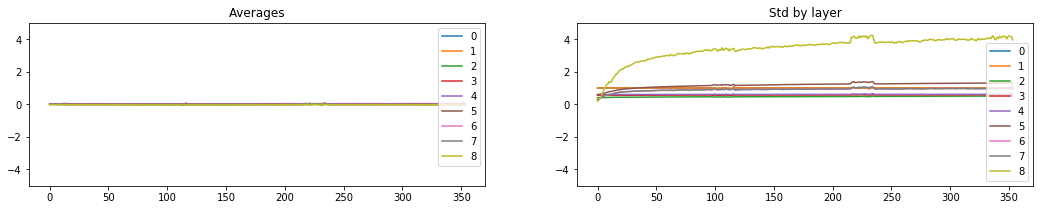

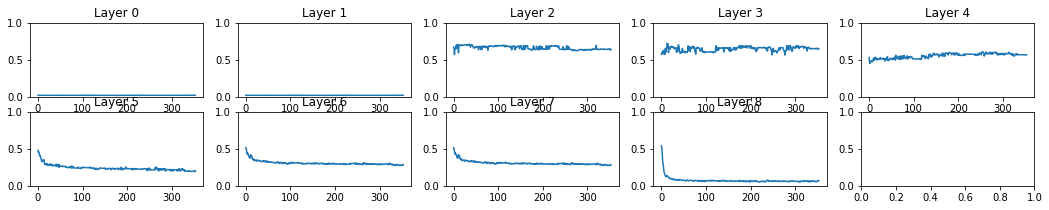

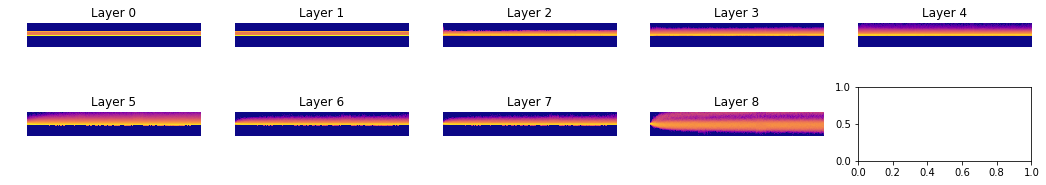

In [15]:
def train_and_show_telemetry(model, callbacks = [], lr = 1):
  loss_func = F.cross_entropy
  opt = optim.SGD(model.parameters(), lr=lr)
  learner = Learner(model, opt, loss_func, data)

  cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()] + listify(callbacks)
  runner = Runner(cbfs)

  hist_hook = HistHook()
  with Hooks(model, hist_hook) as hooks:
    runner.fit(3, learner)
    
  draw_avgs(hooks)
  draw_activations_around_zero(hooks)
  draw_activation_hists(hooks)
  
train_and_show_telemetry(get_my_model(my_conv_with_standard_bn))

In [0]:
def order(f, order = 0):
  f._order = order
  return f

train: [0.60122734375, tensor(0.8296, device='cuda:0')]
valid: [0.3488328857421875, tensor(0.8943, device='cuda:0')]
train: [0.2594863671875, tensor(0.9249, device='cuda:0')]
valid: [0.21333154296875, tensor(0.9386, device='cuda:0')]
train: [0.2038863671875, tensor(0.9401, device='cuda:0')]
valid: [0.18094622802734375, tensor(0.9480, device='cuda:0')]


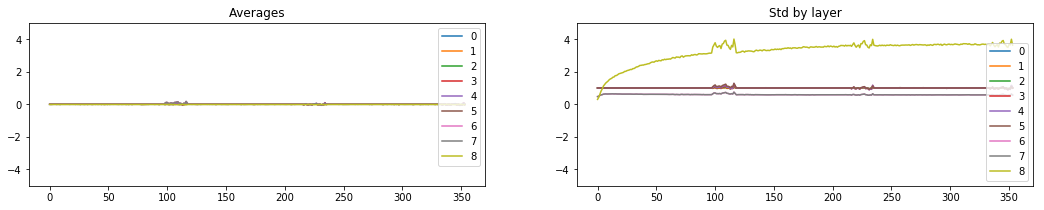

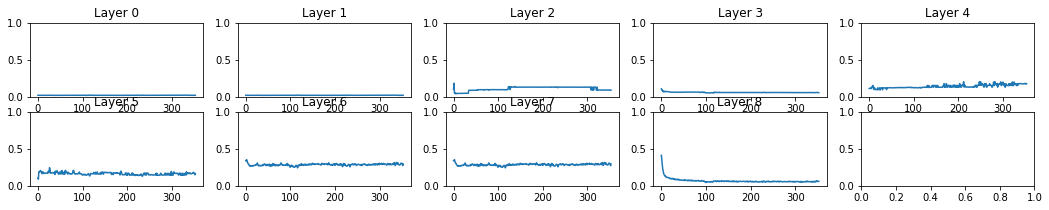

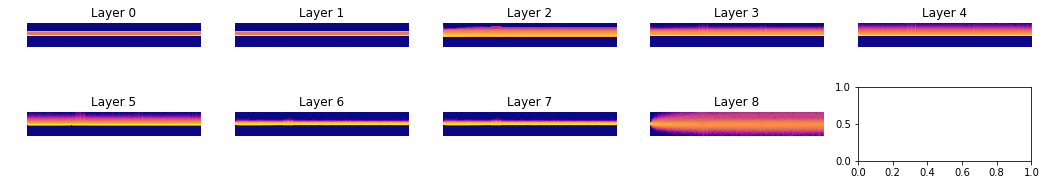

In [17]:
scheduler = combine_scheds([0.3, 0.7], [sched_cos(1, 2), sched_cos(2, 0.5)])
sched_callback = [ParamScheduler('lr', scheduler)]
train_and_show_telemetry(
    get_my_model(my_conv_with_bn_v2),
    sched_callback)

train: [0.5027444140625, tensor(0.8587, device='cuda:0')]
valid: [0.234173388671875, tensor(0.9280, device='cuda:0')]
train: [0.213985234375, tensor(0.9382, device='cuda:0')]
valid: [0.17178895263671876, tensor(0.9487, device='cuda:0')]
train: [0.17155181640625, tensor(0.9504, device='cuda:0')]
valid: [0.14962835693359375, tensor(0.9579, device='cuda:0')]


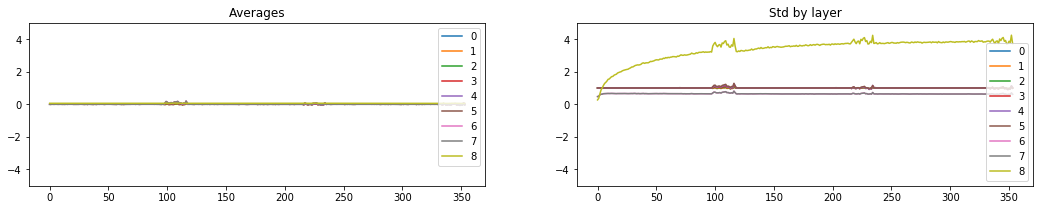

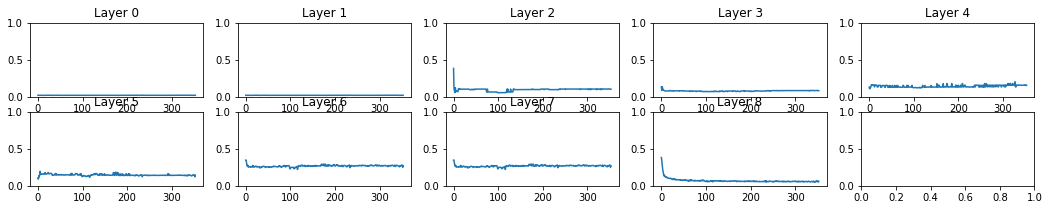

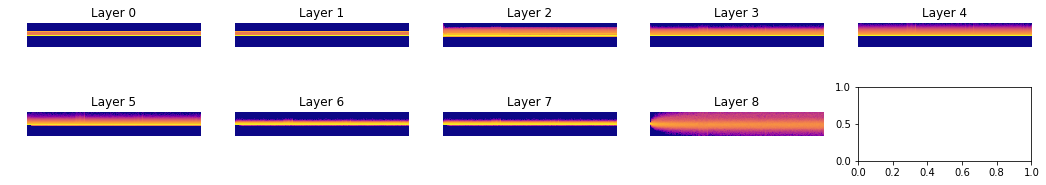

In [18]:
scheduler = combine_scheds([0.3, 0.7], [sched_lin(1, 2), sched_cos(2, 0.5)])
sched_callback = [ParamScheduler('lr', scheduler)]
train_and_show_telemetry(
    get_my_model(my_conv_with_bn_v2),
    sched_callback)

train: [0.745490859375, tensor(0.7772, device='cuda:0')]
valid: [0.2103425048828125, tensor(0.9397, device='cuda:0')]
train: [0.17927552734375, tensor(0.9452, device='cuda:0')]
valid: [0.14230836181640624, tensor(0.9577, device='cuda:0')]
train: [0.1099909765625, tensor(0.9662, device='cuda:0')]
valid: [0.10424677734375, tensor(0.9682, device='cuda:0')]


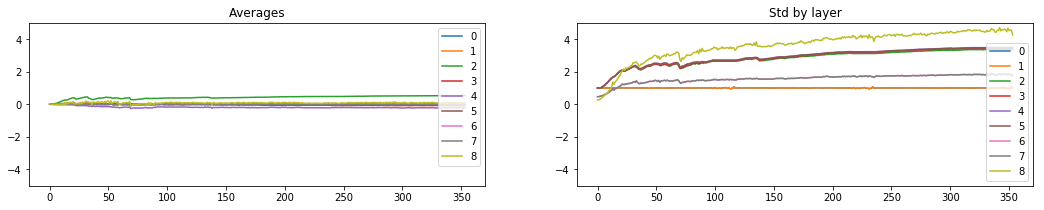

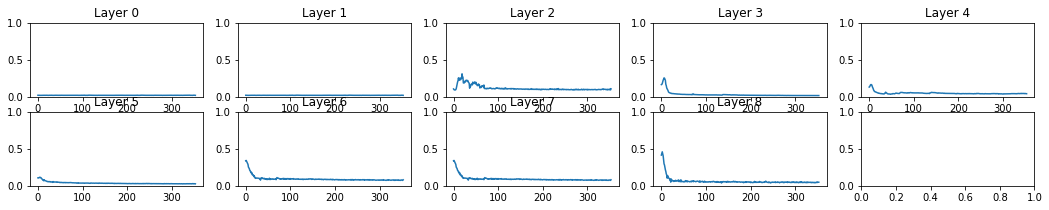

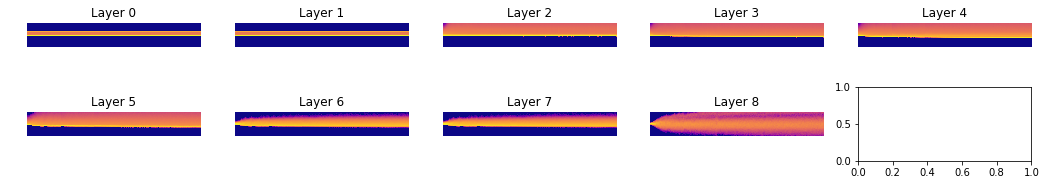

In [19]:
class LayerNorm(nn.Module):
  def __init__(self, momentum=0.9, eps=1e-5):
    super().__init__()
    self.eps = eps
    self.momentum = 1 - momentum
    self.mults = nn.Parameter(tensor(1.))
    self.adds = nn.Parameter(tensor(0.))

  def forward(self, x):
    BATCH, CHANNEL, X, Y = 0,1,2,3
    by_layer = (CHANNEL, X, Y)
    with torch.no_grad():
      current_vars  = x.var(by_layer, keepdim=True)
      current_means = x.mean(by_layer, keepdim=True)

    x_norm = (x - current_means) / torch.sqrt(current_vars + self.eps)
    return x_norm * self.mults + self.adds
    
def my_conv_with_layer_norm(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
      nn.ReLU(),
      LayerNorm()
  )

# Note to self: end result looks nice, had to use much smaller LR's though
scheduler = combine_scheds([0.3, 0.7], [sched_lin(0.1, 0.8), sched_lin(0.8, 0.5)])
sched_callback = [ParamScheduler('lr', scheduler)]
train_and_show_telemetry(
    get_my_model(my_conv_with_layer_norm),
    sched_callback)

train: [2.3032303125, tensor(0.1087, device='cuda:0')]
valid: [2.3019478515625, tensor(0.1064, device='cuda:0')]
train: [2.30128171875, tensor(0.1136, device='cuda:0')]
valid: [2.30199921875, tensor(0.1064, device='cuda:0')]
train: [2.30113796875, tensor(0.1136, device='cuda:0')]
valid: [2.30191796875, tensor(0.1064, device='cuda:0')]


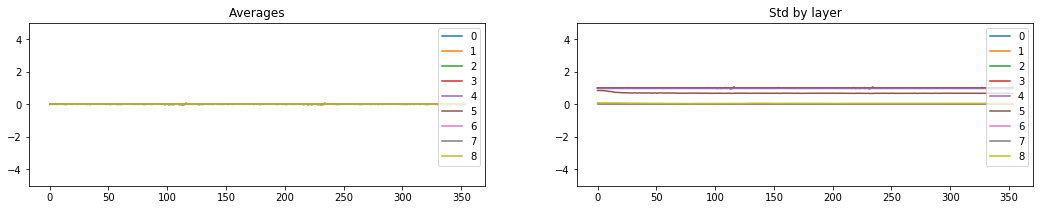

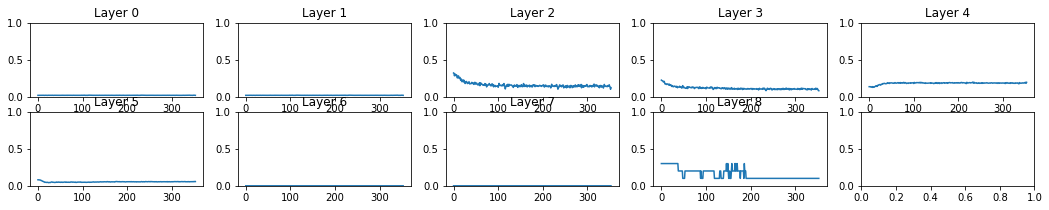

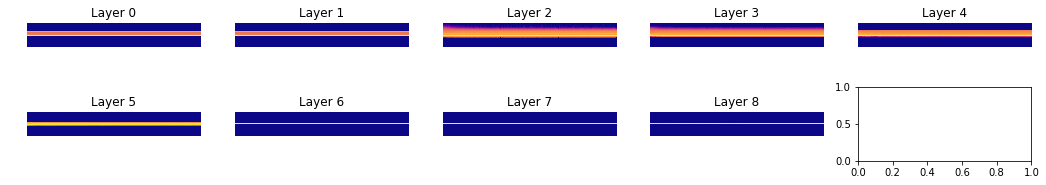

In [20]:
class InstanceNorm(nn.Module):
  def __init__(self, momentum=0.9, eps=1e-5):
    super().__init__()
    self.eps = eps
    self.momentum = 1 - momentum
    
  def _init_if_necessary(self, x):
    if hasattr(self, 'mults'):
      return

    dims = (x.shape[1], 1, 1)
    self.mults = nn.Parameter(torch.ones(dims).to(x.device))
    self.adds = nn.Parameter(torch.zeros(dims).to(x.device))
    self.register_buffer('means', torch.zeros(dims).to(x.device))
    self.register_buffer('vars', torch.ones(dims).to(x.device))

  def forward(self, x):
    BATCH, CHANNEL, X, Y = 0,1,2,3
    by_image = (X, Y)
    self._init_if_necessary(x)
    with torch.no_grad():
      current_vars  = x.var(by_image, keepdim=True)
      current_means = x.mean(by_image, keepdim=True)

    x_norm = (x - current_means) / torch.sqrt(current_vars + self.eps)
    return x_norm * self.mults + self.adds
    
def my_conv_with_instance_norm(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
      nn.ReLU(),
      InstanceNorm()
  )

# Note to self: doesn't seem much trainable
scheduler = combine_scheds([0.3, 0.7], [sched_lin(0.01, 0.5), sched_lin(0.5, 0.01)])
sched_callback = [ParamScheduler('lr', scheduler)]
train_and_show_telemetry(
    get_my_model(my_conv_with_instance_norm),
    sched_callback)

train: [0.358747578125, tensor(0.8982, device='cuda:0')]
valid: [0.08795310668945312, tensor(0.9741, device='cuda:0')]
train: [0.0759696826171875, tensor(0.9771, device='cuda:0')]
valid: [0.06854600219726563, tensor(0.9796, device='cuda:0')]
train: [0.0546444091796875, tensor(0.9834, device='cuda:0')]
valid: [0.06242926025390625, tensor(0.9815, device='cuda:0')]


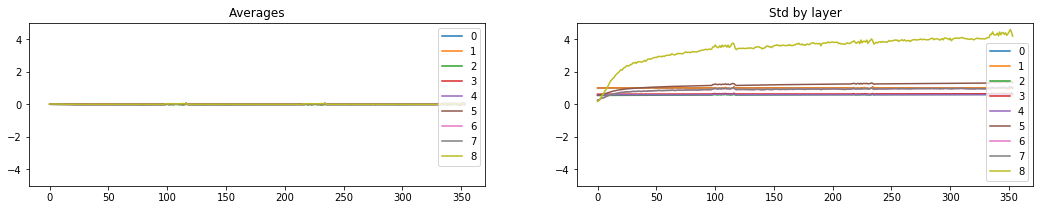

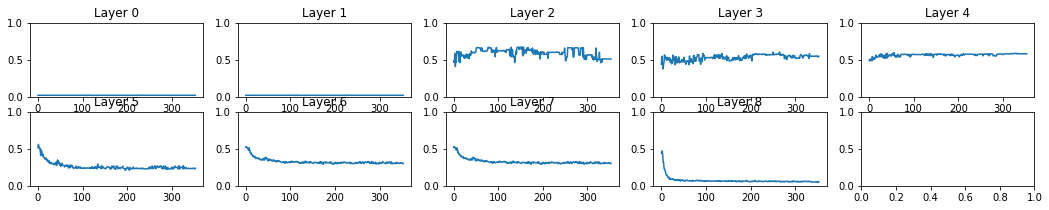

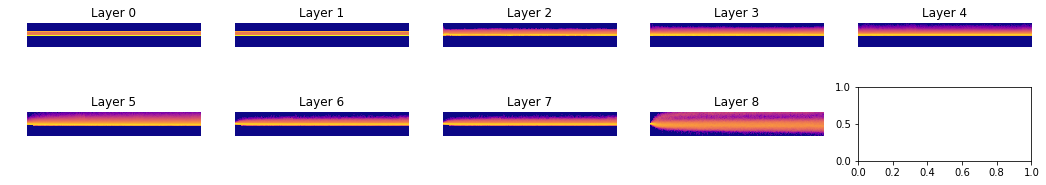

In [21]:
train_and_show_telemetry(get_my_model(my_conv_with_standard_bn))

train: [0.454465625, tensor(0.8795, device='cuda:0')]
valid: [0.09835347290039062, tensor(0.9716, device='cuda:0')]
train: [0.08336189453125, tensor(0.9750, device='cuda:0')]
valid: [0.08493123779296875, tensor(0.9758, device='cuda:0')]
train: [0.0582520751953125, tensor(0.9821, device='cuda:0')]
valid: [0.06806410522460937, tensor(0.9798, device='cuda:0')]


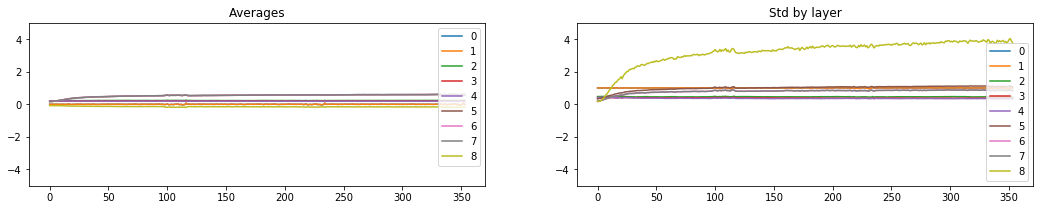

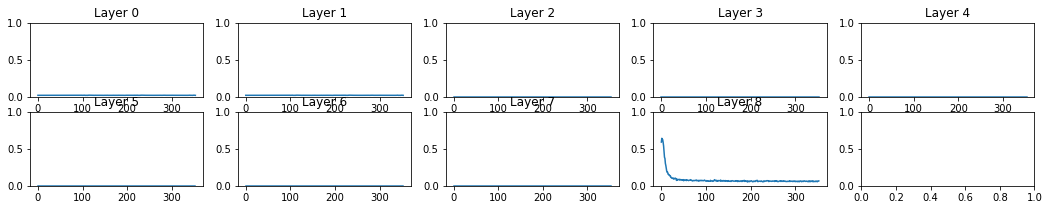

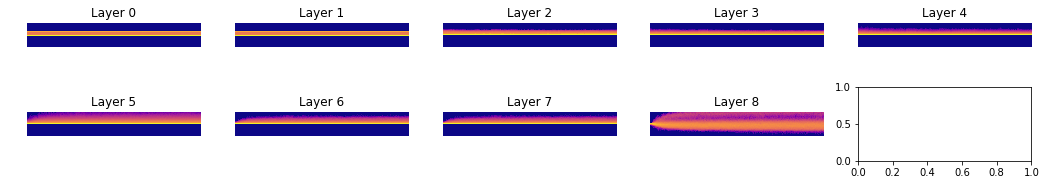

In [22]:
def my_conv_with_standard_bn_before_relu(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

# Note to self: less zero activations here, metrics are otherwise close though
train_and_show_telemetry(get_my_model(my_conv_with_standard_bn_before_relu))

train: [0.3347069921875, tensor(0.9000, device='cuda:0')]
valid: [0.614800634765625, tensor(0.9586, device='cuda:0')]
train: [0.29269548828125, tensor(0.9169, device='cuda:0')]
valid: [6.347047265625, tensor(0.9227, device='cuda:0')]
train: [0.1797574609375, tensor(0.9456, device='cuda:0')]
valid: [7.359590625, tensor(0.9489, device='cuda:0')]


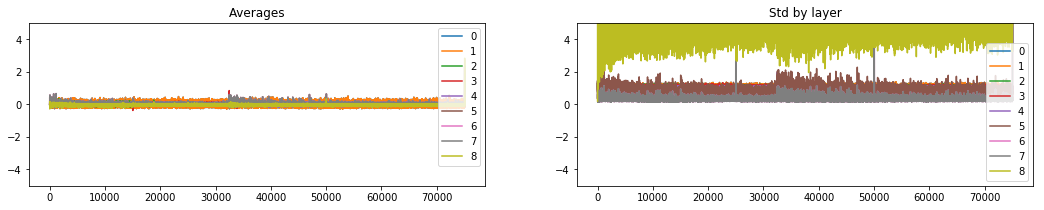

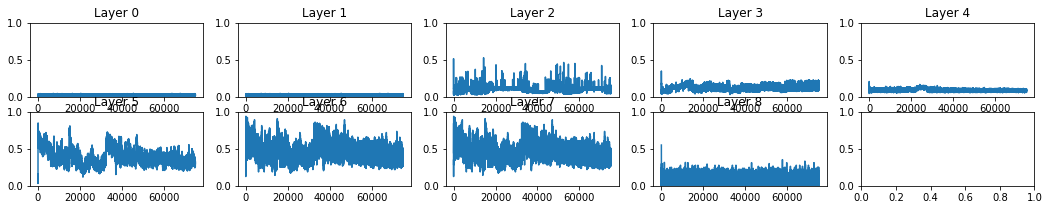

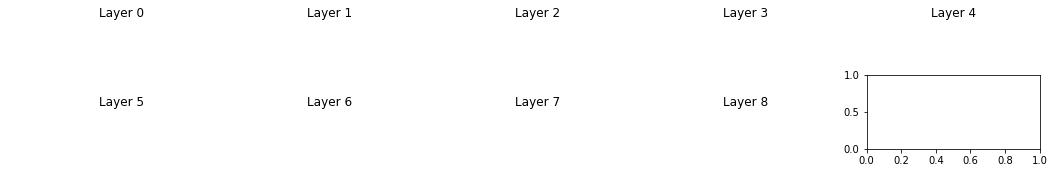

In [106]:

def my_conv_with_running_norm(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
      nn.ReLU(),
      RunningNorm()
  )

def train_and_show_telemetry(model, callbacks = [], lr = 1, data_param = data):
  loss_func = F.cross_entropy
  opt = optim.SGD(model.parameters(), lr=lr)
  learner = Learner(model, opt, loss_func, data_param)

  cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback(), ProgressCallback()] + listify(callbacks)
  runner = Runner(cbfs)

  hist_hook = HistHook()
  with Hooks(model, hist_hook) as hooks:
    runner.fit(3, learner)
    
  draw_avgs(hooks)
  draw_activations_around_zero(hooks)
  draw_activation_hists(hooks)
  
def get_data(batch_size, limit=slice(None, None, None)):
  if isinstance(batch_size, int):
    batch_size = (batch_size, batch_size)
    
  trn_batch_size, val_batch_size = batch_size
  train_ds = TensorDataset(x_train[limit], y_train[limit])
  valid_ds = TensorDataset(x_valid, y_valid)
  train_dl = DataLoader(train_ds, batch_size=trn_batch_size, shuffle = True)
  valid_dl = DataLoader(valid_ds, batch_size=val_batch_size, shuffle = False)

  data = DataBunch(train_dl, valid_dl)
  return data

# Note to self: anything taking longer than a minute should have a progress bar or some sort of liveness indication
import time
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time
class ProgressCallback(Callback):
    _order=-1
    def begin_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.run.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self): self.mbar.on_iter_end()
    def after_batch(self): self.pb.update(self.n_iter)
    def begin_epoch   (self): self.set_pb()
    def begin_validate(self): self.set_pb()

    def set_pb(self):
        self.pb = progress_bar(self.data.train_dl, parent=self.mbar, auto_update=False)
        self.mbar.update(self.epoch)

"""
class BatchNormV2(nn.Module):
  def __init__(self, momentum=0.9, eps=1e-5):
    super().__init__()
    self.eps = eps
    self.momentum = 1 - momentum

  def forward(self, x):
    BATCH,CHANNEL,X,Y = 0,1,2,3
    by_channel = (BATCH, X, Y)
    if (self.training):
      self._init_if_necessary(x)
      with torch.no_grad():
        channel_vars  = x.var(by_channel, keepdim=True)
        channel_means = x.mean(by_channel, keepdim=True)
        self.means.lerp_ (channel_means, self.momentum)
        self.vars.lerp_(channel_vars, self.momentum)
    else:
      channel_vars = self.vars
      channel_means = self.means

    # Note to self: using the actual and not exp avg vals during training seem to be important!
    x_norm = (x - channel_means) / torch.sqrt(channel_vars + self.eps)
    return x_norm * self.mults + self.adds
  
  def _init_if_necessary(self, x):
    if hasattr(self, 'mults'):
      return

    dims = (1, x.shape[1], 1, 1)
    self.mults = nn.Parameter(torch.ones(dims).to(x.device))
    self.adds = nn.Parameter(torch.zeros(dims).to(x.device))
    self.register_buffer('means', torch.zeros(dims).to(x.device))
    self.register_buffer('vars', torch.ones(dims).to(x.device))"""
class RunningNorm(nn.Module):
  def __init__(self, momentum = 0.9, eps = 1e-5):
    super().__init__()
    self.eps = eps
    self.momentum = 1 - momentum
  
  def forward(self, x_original):
    BATCH, CHANNEL, X, Y = 0, 1, 2, 3
    dims = (BATCH, X, Y)
    by_channel = {'dim': dims, 'keepdim': True}
    agg = by_channel
    x = x_original.detach()
    self._init_if_necessary(x)
    current_mean = x.mean(**agg)
    current_var = x.var(**agg)
    mean_estimate = current_mean
    var_estimate = current_var
    if self.training:
      batch_size = x.shape[BATCH]
      current_sum = x.sum(**agg)
      adjusted_momentum = current_sum.new_tensor(1 - (1-self.momentum)/math.sqrt(batch_size-1))
      numel = current_sum.new_tensor(x.shape[BATCH] * x.shape[X] * x.shape[Y])
      self.squares.lerp_((x*x).sum(**agg), adjusted_momentum)
      self.vars.lerp_(current_var, adjusted_momentum)
      self.sums.lerp_(current_sum, adjusted_momentum)
      self.counts.lerp_(numel, adjusted_momentum)
      self.batch += batch_size

    mean_estimate = self.sums / self.counts
    var_estimate = self.squares / self.counts - mean_estimate**2
    if bool(self.batch < 20):
      var_estimate.clamp_min_(0.01)

    x_norm = (x_original - mean_estimate) / (var_estimate + self.eps).sqrt()
    return x_norm * self.scale + self.shift
  
  def _init_if_necessary(self, x):
    BATCH, CHANNEL, X, Y = 0, 1, 2, 3
    if not hasattr(self, 'scale'):
      dims = (1, x.shape[CHANNEL], 1, 1)
      self.scale = nn.Parameter(torch.ones(dims).to(x.device))
      self.shift = nn.Parameter(torch.zeros(dims).to(x.device))
      self.register_buffer('squares', torch.zeros(dims).to(x.device))
      self.register_buffer('vars', torch.zeros(dims).to(x.device))
      self.register_buffer('sums', torch.zeros(dims).to(x.device))
      self.register_buffer('counts', tensor(0.).to(x.device))
      self.register_buffer('batch', tensor(0.).to(x.device))

train_and_show_telemetry(
    get_my_model(my_conv_with_running_norm),
    data_param=get_data(
        batch_size=(2, 512)))

In [0]:
# BatchNorm module
# plot mean/std, hists before & after that
# compare with builtin
# try with scheduler 0.3, 0.7 lin
# layer norm
# instance norm
# group norm
# single epoch
# ---
# running batch norm -- more time needed

In [0]:
# what if I were lazy to upgrade to pytorch-nightly
def m_var(ex, target_dim):
  return ex.transpose(target_dim,0).contiguous().view((ex.shape[target_dim], -1)).var(dim=1)

ex = torch.empty((5,11,3,3)).uniform_()
test_near(m_var(ex, 1), ex.var((0,2,3)))

In [102]:
%debug

> /content/exp/nb_05b.py(12)__getattr__()
     10     _order=0
     11     def set_runner(self, run): self.run=run
---> 12     def __getattr__(self, k): return getattr(self.run, k)
     13 
     14     @property

ipdb> self.n_epoch
*** AttributeError: 'Runner' object has no attribute 'n_epoch'
ipdb> dir(self)
['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_order', 'after_batch', 'after_fit', 'begin_epoch', 'begin_fit', 'begin_validate', 'mbar', 'name', 'pb', 'run', 'set_pb', 'set_runner']
ipdb> dir(seld.run)
*** NameError: name 'seld' is not defined
ipdb> dir(self.run)
['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__',